<a href="https://colab.research.google.com/github/amitmakashir/Deep-learning/blob/master/Assignment4/part2_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import math
import pandas
import pickle
import seaborn as sns
import itertools
import copy

sns.set(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

In [0]:
# These files are output of stft.load()

with open('hw4_tr7.pkl', 'rb') as handle:
    tr7 = pickle.load(handle)
    
with open('hw4_te7.pkl', 'rb') as handle:
    te7 = pickle.load(handle)

In [0]:
print(tr7.shape)
print(te7.shape)

(6265, 28, 28)
(1028, 28, 28)


In [0]:
class miniBatch():
    '''
    Create mini Batches of the data for training the model
    '''
    def __init__(self,x,batch_size,random=True):
        self.x = x
        
        if random:
            self.randomizeInputs()

        if type(x) == "numpy.ndarray":
            self.rows = x.shape[0]
        else: # If list
            self.rows = len(x)
            
        self.batch_size = batch_size
        self.curr_index = 0

        # Total number of iterations
        self.iters = math.ceil(self.rows/self.batch_size)
        pass


    def randomizeInputs(self):
        '''
        Shuffles the input data
        '''
        p = np.random.permutation(len(self.x))
        self.x = self.x[p]
        return True


    def nextBatch(self):
        '''
        Return the next batch of data
        If the last batch is not of the batch size, give all the remaining elements
        '''
        batch_size = self.batch_size
        curr_index = self.curr_index
        
        if curr_index + batch_size >= self.rows:
            batch_x = self.x[curr_index:]
        else:
            batch_x = self.x[curr_index:curr_index+batch_size]
        
        # Set the index for the next iteration
        self.curr_index = curr_index + batch_size
        return batch_x
    


In [0]:
miniBatch(tr7,60).nextBatch().shape

(60, 28, 28)

### Encoder

input = x
output = latent vectors

network structure: 

x -> conv2d -> maxpool -> conv2d -> maxpool -> fc layer -> latent vectors (no activation in the last layer)


In [0]:
def encoder(input_x):
    '''
    Encode the input matrix into latent vectors consisting of mu and sigma
    
    inputs = input_x 
    output = latent_vectors
    
    input.shape => (batch_size,28,28)  // We need to reshape to add filters dim
    output.shape => (batch_size,6)  //6 values corresponding to 3 means and 3 sd
    '''
    input_x = tf.reshape(tensor=input_x,shape=(-1,28,28,1))
    
    # ====== Layers ======= #
    
    # Architecture of Network
    layer1 = { "type":"conv2d",
                "filters":16,
                "kernel_size":[2,2],
             }

    layer2 = { "type":"maxpool",
                "pool_size":2,
                "padding":'valid'
             }


    layer3 = { "type":"conv2d",
                "filters":32,
                "kernel_size":2,
             }


    layer4 = { "type":"maxpool",
                "pool_size":2,
                "padding":'valid'
             }


    layers = [layer1,layer2,layer3,layer4]

    
    constructed_network = []
    
    # He initialization
    he_initializer = tf.contrib.layers.variance_scaling_initializer()
        
    for layer in layers:
      
        if len(constructed_network) == 0: # This is the First layer
            this_input = input_x
        else:
            this_input = constructed_network[-1]
   
      
        if layer["type"] == "conv2d":
            current_layer = tf.layers.conv2d( 
                          inputs = this_input,
                         filters = layer["filters"],
                         kernel_size = layer["kernel_size"],
                         strides = 1,
                         padding = "SAME",
                         kernel_initializer = he_initializer,
                         activation = tf.nn.relu
                        )
        
        elif layer["type"] == "maxpool":
            current_layer = tf.layers.max_pooling2d(
                          inputs = this_input,
                          pool_size = layer["pool_size"],
                          strides = layer["pool_size"], # Same as pool size to not consider the same box twice
                          padding='valid')
        
        # Push this layer to network
        constructed_network.append(current_layer)
      
    # Fully connected layers ahead
    # But before that we should flatten our 4d tensor
    flattened_layer = tf.layers.flatten(constructed_network[-1])
    
    second_last_layer = tf.layers.dense(
        inputs = flattened_layer,
        units = 784,
        activation = tf.nn.relu,
        use_bias = True,
        kernel_initializer = he_initializer,
        bias_initializer = tf.zeros_initializer()
        )
    
    dropout_layer = tf.layers.dropout(second_last_layer,
                      rate = 0.1)
    
    mu = tf.layers.dense(
        inputs = dropout_layer,
        units = 3,
        kernel_initializer = tf.contrib.layers.xavier_initializer())
    
    log_sigma_sq = tf.layers.dense(
        inputs = dropout_layer,
        units = 3,
        kernel_initializer = tf.contrib.layers.xavier_initializer())
    
    return mu, log_sigma_sq

In [0]:
# Deconvolution
def decoder(z):
    '''
    Generates a 28x28 matrix from the given codes (encoded vectors)
    
    input => z
    output => generated images
    
    z.shape => (batch_size,3)
    output.shape => (batch_size,28,28)
    '''
    # He initialization
    initializer = tf.contrib.layers.xavier_initializer()
    
    # We'll first need to apply a dense layer to increase the size of the code 
    # vectors
    layer1 = tf.layers.dense( # layer1.shape => (batch_size,28*28)
                            inputs = z,
                            units = 112*112,
                            activation = tf.nn.relu,
                            kernel_initializer = initializer)  
    
    dropout_layer = tf.layers.dropout(layer1,
                      rate = 0.1)
    
    layer1_reshaped = tf.reshape(layer1,shape=(-1,112,112,1))
    
    # ====== Layers ======= #
    
    # Architecture of Network
    layer1 = { "type":"conv2d",
                "filters":1,
                "kernel_size":[2,2],
                "activation": tf.nn.relu
             }

    layer2 = { "type":"maxpool",
                "pool_size":2,
                "padding":'valid'
             }


    layer3 = { "type":"conv2d",
                "filters":1,
                "kernel_size":2,
              "activation": None
             }


    layer4 = { "type":"maxpool",
                "pool_size":2,
                "padding":'valid'
             }


    layers = [layer1,layer2,layer3,layer4]

    
    constructed_network = []
    
    # He initialization
#     he_initializer = tf.contrib.layers.variance_scaling_initializer()
        
    for layer in layers:
      
        if len(constructed_network) == 0: # This is the First layer
            this_input = layer1_reshaped
        else:
            this_input = constructed_network[-1]
   
        
        if layer["type"] == "conv2d":
            current_layer = tf.layers.conv2d( 
                          inputs = this_input,
                         filters = layer["filters"],
                         kernel_size = layer["kernel_size"],
                         strides = 1,
                         padding = "SAME",
                         kernel_initializer = initializer,
                         activation = layer["activation"]
                        )
        
        elif layer["type"] == "maxpool":
            current_layer = tf.layers.max_pooling2d(
                          inputs = this_input,
                          pool_size = layer["pool_size"],
                          strides = layer["pool_size"], # Same as pool size to not consider the same box twice
                          padding='valid')
        
        # Push this layer to network
        constructed_network.append(current_layer)
      
    image_matrix = tf.reshape(constructed_network[-1],(-1,28,28))
    
    return image_matrix

In [0]:
def sampled_codes(mu,sigma):
    '''
    mu.shape => (batch_size,no_of_chosen_means)
    
    Sample a random value from the normal distribution represented by corresponding 
    mu and sigma
    '''
    epsilon = tf.random.normal(shape=tf.shape(mu),dtype=tf.float32)
    
    sampled_values = mu + epsilon*sigma
    
    return sampled_values
    
    
def KL_loss(mu,log_sigma_square):
    '''
    This loss penalizes our model if it tries to learn parameters that are away 
    from the center. Ultimately, this creates a dense cluster of latent space 
    where in all the classes/features we are interested are represented very 
    close to each other. Therefore, if we sample from such a distribution there is 
    a high chance that the generated image will be representative of our training
    data.
    
    
    Inputs:
    mu.shape => (batch,K)  // Here is the number of latent dimensions
    log_sigma_square.shape => (batch,K)
    
    Output:
    loss.shape => () // scalar value
    '''
    loss = 0.5 * tf.reduce_sum(tf.exp(log_sigma_square) + tf.square(mu) - 1 - log_sigma_square)
    return loss

def Reconstruction_loss(x,x_hat,loss_type="mse"):
    '''
    Loss function to penalize for the reconstruction of the images
    Either MSE or cross entropy works well here
    
    Inputs:
    x.shape => (batch,28,28)
    x_hat.shape => (batch,28,28)
    loss_type => string
    
    Output:
    loss.shape => (batch,28,28)
    '''
    if loss_type == "entropy":
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=x,logits=x_hat)
        loss = tf.reduce_sum(loss)
    else:
        loss = tf.reduce_mean(tf.square(decoded_images-x))
    
    return loss
    

In [0]:
batch_size = 60
epochs = 300
learning_rate = 0.003

In [0]:
tf.reset_default_graph()

# Create placeholders for input X and labels y
x = tf.placeholder(tf.float32, [None,28,28])

# Choose the first 3 columns as means and last 3 as sigmas for those means
mu,log_sigma_square = encoder(x)  # encoded_vecs.shape => (batch_size,6)

sigma = tf.exp(0.5 * log_sigma_square)

# Randomly sample from this distribution and pass this code to the decoder
# z = mu + e*sigma   // Here e is sampled from a standard normal distribution
z = sampled_codes(mu,sigma)
logits = decoder(z)

reconstructed_images = tf.sigmoid(logits)


# Now that the images are generated, let's calculate the loss
reconstruction_loss = Reconstruction_loss(x,logits,loss_type="entropy")
kl_loss = KL_loss(mu,log_sigma_square)

combined_loss = reconstruction_loss + kl_loss

train_step = tf.train.AdamOptimizer(learning_rate).minimize(combined_loss)

sess = tf.InteractiveSession()
tf.global_variables_initializer().run()


# Testing miniBatch
test_mini_batch = miniBatch(te7,180)
test_x = test_mini_batch.nextBatch()

test_loss = []
train_loss = []
rloss= []
klloss = []

# ============  Training the network ============ #  
for e in range(epochs):
    # Create minibatches and train data on it
    mini_batch = miniBatch(tr7,batch_size)
    
    for iter in range(mini_batch.iters):
        batch_x = mini_batch.nextBatch()
        sess.run([train_step], feed_dict={x:batch_x})
    
    r,k = sess.run([reconstruction_loss,kl_loss], feed_dict={x:tr7})
    rloss.append(r)
    klloss.append(k)
    test_loss.append(sess.run(combined_loss, feed_dict={x:test_x}))
    
mu_temp,sigma_temp = sess.run([mu,log_sigma_square], feed_dict={x:batch_x})

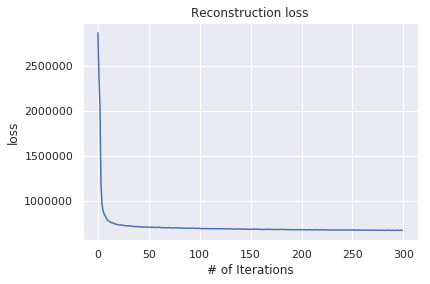

Final Reconstruction loss:  675216.06


In [0]:
# Plotting the Reconstruction loss
sns.set_style("darkgrid")
plt.plot(rloss)
plt.xlabel("# of Iterations")
plt.ylabel("loss")
plt.title("Reconstruction loss")
plt.show()
print("Final Reconstruction loss: ",str(rloss[-1]))

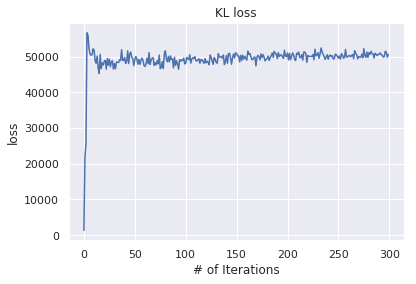

Final KL loss:  50635.86


In [0]:
# Plotting the KL loss
sns.set_style("darkgrid")
plt.plot(klloss)
plt.xlabel("# of Iterations")
plt.ylabel("loss")
plt.title("KL loss")
plt.show()
print("Final KL loss: ",str(klloss[-1]))

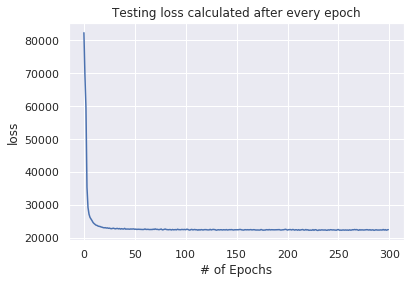

Final testing loss:  22518.906


In [0]:
# Plotting the test loss
sns.set_style("darkgrid")
plt.plot(test_loss)
plt.xlabel("# of Epochs")
plt.ylabel("loss")
plt.title("Testing loss calculated after every epoch")
plt.show()
print("Final testing loss: ",str(test_loss[-1]))

In [0]:
def visualizeImages(images,grid):
    fig, axes = plt.subplots(grid[0], grid[1],figsize=(5.5,5.5), gridspec_kw={'wspace':0.1, 'hspace':0.1})
    for i in range(grid[0]): # row 
        for j in range(grid[1]): # column
            image_no = i*10 + j
            axes[i,j].imshow(images[image_no],cmap="gray")
            axes[i,j].axis('off')
    plt.show()

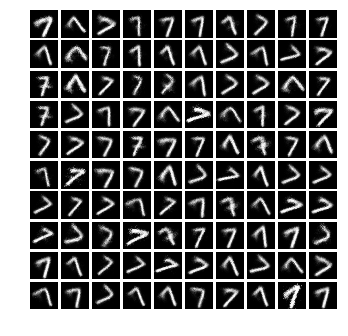

In [0]:
test_mini_batch = miniBatch(te7,500)
test_x = test_mini_batch.nextBatch()
test_images = sess.run(reconstructed_images, feed_dict={x:test_x})

visualizeImages(test_images,[10,10])

In [0]:
# Generate latent vectors from the training data
train_z = sess.run(z, feed_dict={x:tr7})

# Generate some samples to inspect the effects
no_of_samples = 100

# train_z.shape => (total_images,3)
means = np.mean(train_z,axis=0)
mins = np.min(train_z,axis=0)
maxs = np.max(train_z,axis=0)

mean_matrix = np.repeat([[means[0], means[1], means[2]]],[no_of_samples], axis = 0)
mean_matrix.shape

(100, 3)

### Inspecting the effect of each dimension in the latent space

Now we have 3 scalars (3 means corresponding to 3 dimensions of the latent space) generated for all training examples.
To inspect the effect of each dimension, we will vary that dimension and fix the other 2. Because of the KL divergence loss, our means for each column would lie close to 0 and standard deviation around 1. The min and max values observed in the these columns is approx -3 and 3. We are generating 100 images with varying values of that columns to see the effect of that dimension. 

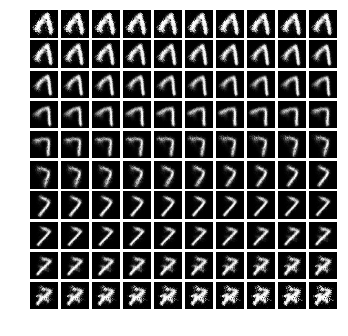

In [0]:
generated_seq = np.linspace(mins[0], maxs[0], num=no_of_samples)
a = copy.deepcopy(mean_matrix)
a[:,0] = generated_seq
images_1 = sess.run(reconstructed_images, feed_dict={z:a})

visualizeImages(images_1,[10,10])

In the above plot, you can see that initially the 7's are almost like A's. The first few rows have negative values. In the middle rows, the 7's starts becomeing straight by rotating clockwise. These are values around 0. In the last rows, the 7's continue rotating clockwise and there is a noticeable difference in the thickness.


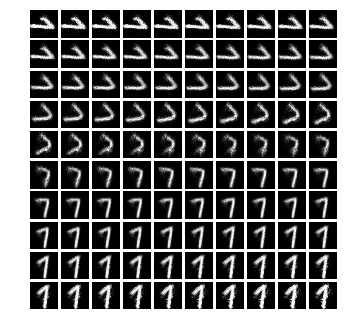

In [0]:
generated_seq = np.linspace(mins[1], maxs[1], num=no_of_samples)
b = copy.deepcopy(mean_matrix)
b[:,1] = generated_seq
images_2 = sess.run(reconstructed_images, feed_dict={z:b})
visualizeImages(images_2,[10,10])

The 7's start out as 1's that are horizontal. Towards the middle, the 7's look they are 7's. There is a tendency to rotate anti-clockwise in this dimension of the latent space. Towards the end, the 7's look a lot like 1's due to the anti-clockwise rotation. 

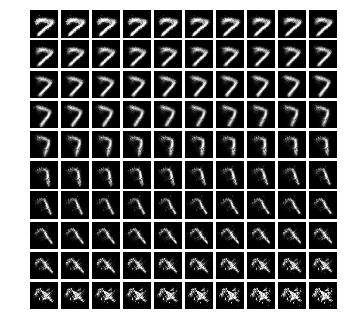

In [0]:
generated_seq = np.linspace(mins[2], maxs[2], num=no_of_samples)
c = copy.deepcopy(mean_matrix)
c[:,2] = generated_seq
images_3 = sess.run(reconstructed_images, feed_dict={z:c})
visualizeImages(images_3,[10,10])

This dimension has the A's like looking characteristic similar to the dimension 1 and anti-clockwise rotation tendency similar to dimension 2. Towards, the start the images are a lot like horizontal A's and then they go on to become 7's and continue to rotate.